In [2]:
# initiation: 2020-02-10T15:00:00+01:00
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
import seaborn as sns
import constrNMPy
import os

plt.rcParams['font.sans-serif'] = ['Times New Roman'] # set the font inline to Times New Roman

## 题目二

在一个心理物理学实验中，主试向被试呈现不同强度的刺激，被试需要在他们认为有刺激出现的试次做出反应，对于不同的刺激强度$I$，被试反应的概率为($c_t=1$表示做出反应，$c_t=0$表示不反应)
$$P(c_t=1|I)=p_g+\frac{1-p_l-p_g}{1+exp(b(a-I))}$$

### Q1
    
假设模型参数取值为$p_g=0.2, p_l=0.2, b=0.2, a=20$,请画出被试反应概率随刺激强度变化的曲线($I\in[0,50]$)。然后随机生成150个试次的实验，每个试次的刺激强度独立，服从[0,50]上的均匀分布，并根据模型生成被试在实验中的反应。请在代码中指定随机种子为你的学号。

your answer here

In [1]:
def Weibull(I, a, b, pg, pl):
    """
    Compute the value of the psychometric curve based on the fomula given parameters and stimulus intensity.
    
    Inputs:
        I (float): Stimulus intensity.
        a (float): Bias parameter.
        b (float): Slope parameter.
        pg (float): Guess rate.
        pl (float): Lapse rate.
        
    Returns:
        float: The probability of detecting the stimulus (c_t=1) given the stimulus intensity I.
    """
    return pg + (1 - pg - pl) / (1 + np.exp(b * (a - I)))

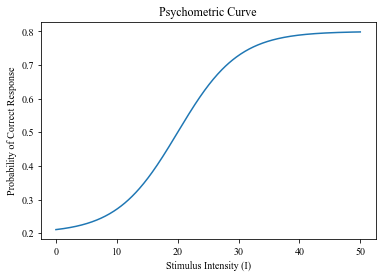

In [3]:
model_params = [20, 0.2, 0.2, 0.2] # initial set of the parameters

# 生成刺激强度I的取值范围
I_range = np.linspace(0, 50, 500)

# 计算心理物理曲线上每个点的取值
P = Weibull(I_range,*model_params) # *model_params is equivalent to model_params[0], model_params[1], model_params[2], model_params[3]

# 绘制心理物理曲线图
plt.plot(I_range, P)
plt.xlabel('Stimulus Intensity (I)')
plt.ylabel('Probability of Correct Response')
plt.title('Psychometric Curve')
plt.show()


Stimulus Intensities: [26.81051618  5.6798309  10.86010338 11.00743082  2.63917993 16.48768821
 42.91467942 12.31662097 36.9401964  41.67282793]
Responses: [1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]


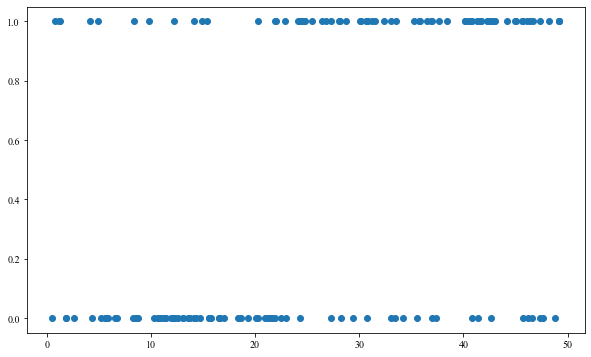

In [9]:
np.random.seed(2000017819)

# 生成150个刺激强度值
I_trials = np.random.uniform(low=0, high=50, size=150)

# 生成150个试次的反应
responses = np.zeros_like(I_trials)
for i in range(len(I_trials)):
    p_correct = Weibull(I_trials[i], *model_params)
    if np.random.rand() < p_correct:
        responses[i] = 1

# 打印前10个试次的刺激强度和反应
print('Stimulus Intensities:', I_trials[:10])
print('Responses:', responses[:10])

df = pd.DataFrame({'I': I_trials, 'c': responses})
df.head()

plt.figure(figsize=(10, 6))
# scatter plot of the data
plt.scatter(df['I'], df['c'], label='Data');

### Q2
    
请根据Q1中生成的实验数据，使用最大似然估计拟合模型参数，报告参数并画出拟合得到的模型反应概率随刺激强度变化的曲线，请注意参数的取值范围$p_g\in[0,1],p_l\in[0,1],b\in[0,\inf)$


In [5]:
# the distribution of number of correct response for each stimulus intensity follows a Bernoulli distribution
def nlog_likelihood(params, I, c):
    """
    Compute the log likelihood of the data given the model parameters.
    
    Inputs:
        params (list): The model parameters.
        I (numpy.ndarray): The stimulus intensity.
        c (numpy.ndarray): The response.
        
    Returns:
        float: The log likelihood.
    """
    a, b, pg, pl = params
    Prob = Weibull(I, a, b, pg, pl)
    Prob = np.clip(Prob, 0.01, 0.99) # clip the probability to avoid numerical error
    log_likelihood = np.sum(c * np.log(Prob) + (1 - c) * np.log(1 - Prob)) # log likelihood of the data given the model parameters
    return -log_likelihood

# Estimate the model parameters using MLE
from scipy.optimize import minimize
model_params = [20, 0.2, 0.2, 0.2]
model_params_est = minimize(nlog_likelihood, model_params, args=(I_trials, responses), method='Nelder-Mead', tol=1e-6).x


print("Estimated parameters using MLE: [a, b, pg, pl] = ", model_params_est)

Estimated parameters using MLE: [a, b, pg, pl] =  [22.70543553  2.33722679  0.19428481  0.25346246]


In [6]:
args = (I_trials, responses)
LB = [1e-4, 1e-4, 1e-4, 1e-4];
UB = [1e2, 10, 1, 1];
[a0] = np.random.uniform(1e-4, 30, 1); [b0, pg0, pl0] = np.random.uniform(1e-4, 1, 3);
x0 = [a0, b0, pg0, pl0];

xopt = constrNMPy.constrNM(nlog_likelihood, x0, LB, UB, args=args, full_output=True)
xopt

{'fopt': 80.86052614380756,
 'iter': 112,
 'funcalls': 193,
 'warnflag': 0,
 'xopt': array([22.70538727,  2.3372701 ,  0.1942727 ,  0.25346916]),
 'allvecs': None}

In [7]:
# Use multiple random starting points to increase the probability of finding the global minimum.
import time
start = time.time()

N_random=10
optimal=[]
for i in range(N_random):
    # print("\r 进度：%.2f%%" %(float(i/N_random*100)),end=' ')
    [a0] = np.random.uniform(1e-4, 30, 1); [b0, pg0, pl0] = np.random.uniform(1e-4, 1, 3);
    x0 = [a0, b0, pg0, pl0];
    xopt = constrNMPy.constrNM(nlog_likelihood, x0, LB, UB, args=args, full_output=True)
    optimal.append(xopt['xopt'])
y = list(map(lambda params: nlog_likelihood(params, I_trials, responses), optimal)) # optional: use full output from constrNM
opt = optimal[y.index(min(y))]
print('MLE [a, b, pg, pl] = ' + str(opt))

print('time used: ', str(time.time()-start), ' seconds')

MLE [a, b, pg, pl] = [22.70548422  2.33732982  0.19428511  0.25345957]
time used:  0.2505638599395752  seconds


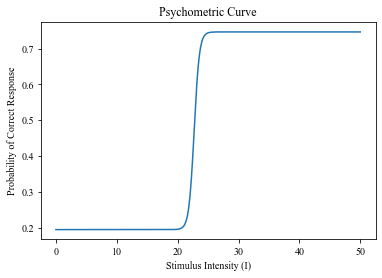

In [10]:
# 生成刺激强度I的取值范围
I_range = np.linspace(0, 50, 500)

# 计算心理物理曲线上每个点的取值
P = Weibull(I_range,*opt) # *model_params is equivalent to model_params[0], model_params[1], model_params[2], model_params[3]

# 绘制心理物理曲线图（对于拟合出来的模型）
plt.plot(I_range, P)
plt.xlabel('Stimulus Intensity (I)')
plt.ylabel('Probability of Correct Response')
plt.title('Psychometric Curve')
plt.show()

### Q3
    
请根据Q1中生成的实验数据，使用nonparametric bootstrap估计参数的95%置信区间(采样400次)
 

In [ ]:
res = []
n_iterations = 40 # number of iterations
N_random= 10 # number of random starting points
for i in range(n_iterations):
    # sampling from data
    bootstrap_indices = np.random.choice(range(150), size=150, replace=True)
    df_new = df.loc[bootstrap_indices]
    [I_new,responce_new] =  [df_new['I'].values, df_new['c'].values]
    args = (I_new, responce_new);
    LB = [1e-4, 1e-4, 1e-4, 1e-4];
    UB = [1e2, 10, 1, 1];
    optimal=[]
    for i in range(N_random):
        # print("\r 进度：%.2f%%" %(float(i/N_random*100)),end=' ')
        [a0] = np.random.uniform(1e-4, 30, 1); [b0, pg0, pl0] = np.random.uniform(1e-4, 1, 3);
        x0 = [a0, b0, pg0, pl0];
        xopt = constrNMPy.constrNM(nlog_likelihood, x0, LB, UB, args=args, full_output=True)
        optimal.append(xopt['xopt'])
    y = list(map(lambda params: nlog_likelihood(params, I_trials, responses), optimal)) # optional: use full output from constrNM
    opt = optimal[y.index(min(y))]
    res.append(optimal[y.index(min(y))])
res = np.array(res)

In [ ]:
# 绘制心理物理曲线图（对于拟合出来的模型）
_, ax = plt.subplots(figsize=(6, 3))
for i in range(len(res)):
    P = Weibull(I_range,*res[i])
    ax.plot(I_range, P, color='gray', alpha=0.2)
    
ax.plot(I_range,Weibull(I_range,*model_params_est) , lw=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Intensity I')
ax.set_ylabel('Probability Correct [ P(C) ]')
ax.set_title('Bootstrapping results')

In [ ]:
# the distribution of the parameters
_, ax = plt.subplots(2,2,figsize=(9, 6))
sns.histplot(res[:, 0], stat="probability", element="step", color='k', alpha=0.5, label=r'a', ax=ax[0, 0])
ax[0, 0].set_xlabel(r'a')
sns.histplot(res[:, 1], stat="probability", element="step", color='k', alpha=0.5, label=r'b', ax=ax[0, 1])
ax[0, 1].set_xlabel(r'b')
sns.histplot(res[:, 2], stat="probability", element="step", color='k', alpha=0.5, label=r'pl', ax=ax[1, 0])
ax[1, 0].set_xlabel(r'pl')
sns.histplot(res[:, 3], stat="probability", element="step", color='k', alpha=0.5, label=r'pg', ax=ax[1, 1])
ax[1, 1].set_xlabel(r'pg')
for each in ax.ravel():
    each.spines['right'].set_visible(False)
    each.spines['top'].set_visible(False)
    each.set_title('Bootstrapping results')
    each.legend(fontsize='small', shadow=False, frameon=False)


95% CI

In [ ]:
alpha=95
print('Non-parametric bootstrapping 95%CI:')
print('a:', np.percentile(res[:, 0], (100-alpha)/2), np.percentile(res[:, 0], 100-(100-alpha)/2))
print('b:', np.percentile(res[:, 1], (100-alpha)/2), np.percentile(res[:, 1], 100-(100-alpha)/2))
print('pl:', np.percentile(res[:, 1], (100-alpha)/2), np.percentile(res[:, 2], 100-(100-alpha)/2))
print('pg:', np.percentile(res[:, 1], (100-alpha)/2), np.percentile(res[:, 3], 100-(100-alpha)/2))

# Parametric bootstrapping

In [ ]:
respb = [] # store the results
n_iterations = 40 # number of iterations
N_random= 10 # number of random starting points
LB = [1e-4, 1e-4, 1e-4, 1e-4];
UB = [1e2, 10, 1, 1];

for i in range(n_iterations):
    
    # sampling from the model
    # 生成150个刺激强度值
    I_new = np.random.uniform(low=0, high=50, size=150)
    # 生成150个试次的反应
    response_new = np.zeros_like(I_new)
    for i in range(len(I_new)):
        p_correct = Weibull(I_new[i], *model_params_est)
        if np.random.rand() < p_correct:
            response_new[i] = 1
            
    args = (I_new, response_new);

    optimal=[]
    for i in range(N_random):
        # print("\r 进度：%.2f%%" %(float(i/N_random*100)),end=' ')
        [a0] = np.random.uniform(1e-4, 30, 1); [b0, pg0, pl0] = np.random.uniform(1e-4, 1, 3);
        x0 = [a0, b0, pg0, pl0];
        xopt = constrNMPy.constrNM(nlog_likelihood, x0, LB, UB, args=args, full_output=True)
        optimal.append(xopt['xopt'])
    y = list(map(lambda params: nlog_likelihood(params, I_trials, responses), optimal)) # optional: use full output from constrNM
    opt = optimal[y.index(min(y))]
    respb.append(optimal[y.index(min(y))])
respb = np.array(respb)

In [ ]:
# 绘制心理物理曲线图（对于拟合出来的模型）
_, ax = plt.subplots(figsize=(6, 3))
for i in range(len(respb)):
    P = Weibull(I_range,*respb[i])
    ax.plot(I_range, P, color='gray', alpha=0.2)
    
ax.plot(I_range,Weibull(I_range,*model_params_est) , lw=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Intensity I')
ax.set_ylabel('Probability Correct [ P(C) ]')
ax.set_title('Bootstrapping results')

In [ ]:
# the distribution of the parameters
_, ax = plt.subplots(2,2,figsize=(9, 6))
sns.histplot(respb[:, 0], stat="probability", element="step", color='k', alpha=0.5, label=r'a', ax=ax[0, 0])
ax[0, 0].set_xlabel(r'a')
sns.histplot(respb[:, 1], stat="probability", element="step", color='k', alpha=0.5, label=r'b', ax=ax[0, 1])
ax[0, 1].set_xlabel(r'b')
sns.histplot(respb[:, 2], stat="probability", element="step", color='k', alpha=0.5, label=r'pl', ax=ax[1, 0])
ax[1, 0].set_xlabel(r'pl')
sns.histplot(respb[:, 3], stat="probability", element="step", color='k', alpha=0.5, label=r'pg', ax=ax[1, 1])
ax[1, 1].set_xlabel(r'pg')
for each in ax.ravel():
    each.spines['right'].set_visible(False)
    each.spines['top'].set_visible(False)
    each.set_title('Bootstrapping results')
    each.legend(fontsize='small', shadow=False, frameon=False)